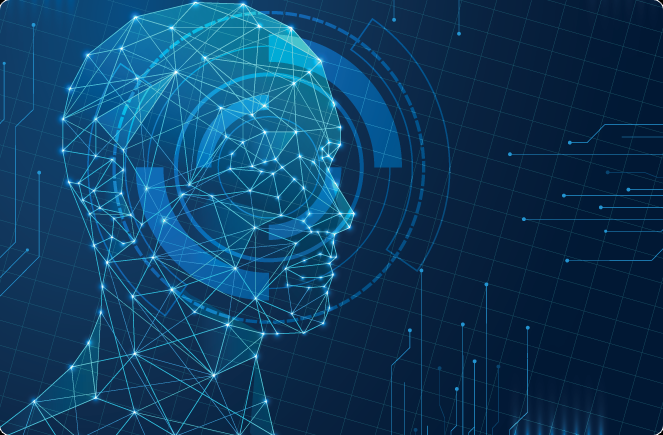

# <div align="center"> Computer Vision

### *Objective*
-----
The objective of this project is to build a model that will give us the category of image.

In [1]:
"""
We are using transfer learning in this network for that we have imported VGG16.
We use VGG16 model to train our network and at end we will put a layer,
which will define number of number of category we want to classify.

"""
from keras.layers import Input, Lambda, Dense, Flatten, merge, Activation #This is used to input our data which we want to test
from keras.models import Model  
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet import MobileNet  #designed for mobile and embedded vision applications
from keras.applications.vgg16 import preprocess_input, decode_predictions  
from keras.preprocessing import image              #Because our i/p is images
from keras.preprocessing.image import ImageDataGenerator, load_img   #It will help to do data augmentation
from keras.models import Sequential        #We are creating a sequential model
import numpy as np
import pandas as pd
from glob import glob
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train

,Image,Class
0,image7042.jpg,Food
1,image3327.jpg,misc
2,image10335.jpg,Attire
3,image8019.jpg,Food
4,image2128.jpg,Attire
...,...,...
5978,image2494.jpg,Food
5979,image8015.jpg,Attire
5980,image4975.jpg,Food
5981,image1222.jpg,Food


In [4]:
s = train['Class'].tolist()

In [5]:
from collections import Counter
counter=Counter(s)
df_temp=pd.DataFrame({'category':list(counter.keys()),'count':list(counter.values())})
df_temp

,category,count
0,Food,2278
1,misc,1271
2,Attire,1691
3,Decorationandsignage,743


In [6]:
tg_dict = {"Food":0, "misc": 1, "Attire": 2,"Decorationandsignage":3}
def label_encode(x):
    return tg_dict[x]

In [7]:
train['Class'] = train['Class'].apply(label_encode)
train

,Image,Class
0,image7042.jpg,0
1,image3327.jpg,1
2,image10335.jpg,2
3,image8019.jpg,0
4,image2128.jpg,2
...,...,...
5978,image2494.jpg,0
5979,image8015.jpg,2
5980,image4975.jpg,0
5981,image1222.jpg,0


In [8]:
images = train['Image'].tolist()
classes = train['Class'].tolist()

In [9]:
"""
In the below code we are converting image in (224,224) size.
(224,224) this format is important for VGG16.

"""
features=[]
labels=[]
path= 'Train_Images/'
for i in range(0,5983):
  if os.path.isfile(path+str(images[i])):
    pic = image.load_img(path+str(images[i]), target_size=(224, 224))
    #print(path+str(images[i]))
    x = image.img_to_array(pic)  
    """
    converting image in array format.
    The img_to_array() function adds channels: x.shape = (224, 224, 3) for RGB and (224, 224, 1) for gray image
    
    """
    x = np.expand_dims(x, axis=0)   
    """
    Insert a new axis that will appear at the axis position in the expanded array shape.
    expand_dims() is used to add the number of images: x.shape = (1, 224, 224, 3)
    
    """
    x = preprocess_input(x)
    """
    preprocess_input subtracts the mean RGB channels of the imagenet dataset. 
    This is because the model you are using has been trained on a different dataset: x.shape is still (1, 224, 224, 3)

    """
    features.append(x)
    labels.append(classes[i])
  else:
    print(path+str(images[i]), 'not present')

In [10]:
npfeatures = np.array(features)
print(npfeatures.shape)
"""
(number of images,expanded_dim,image_format)
image_format=(224,224,3):- RGB image

"""

(5983, 1, 224, 224, 3)


'\n(number of images,expanded_dim,image_format)\nimage_format=(224,224,3):- RGB image\n\n'

In [11]:
img_dt = np.rollaxis(npfeatures, 1, 0)
print(img_dt.shape)
"""
The method rollaxis
def rollaxis(a, axis, start=0):
reallocates the chosen axis at the start "position"

"""

(1, 5983, 224, 224, 3)


'\nThe method rollaxis\ndef rollaxis(a, axis, start=0):\nreallocates the chosen axis at the start "position"\n\n'

In [12]:
from keras.utils import np_utils
X = img_dt[0]
print(f"X_shape : {X.shape}")
labels = np.array(labels)
Y = np_utils.to_categorical(labels,4)
"""
np_utils.to_categorical(y, nb_classes=None)
y: class vector to be converted into a matrix
nb_classes: total number of classes
Convert class vector (integers from 0 to nb_classes) to binary class matrix, 
for use with categorical_crossentropy.

This function label data in 4 classes and represent them in 0 and 1 form.

"""
print(f"lebel_shape : {labels.shape}")
print(f"Y_shape : {Y.shape}")

X_shape : (5983, 224, 224, 3)
lebel_shape : (5983,)
Y_shape : (5983, 4)


In [13]:
"""from sklearn.metrics import f1_score
def f1_m(y_true, y_pred):
    return f1_score(y_true, y_pred)"""
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
"""
## Using transfer learning with MobileNet(time_efficient way)

import keras
from keras.layers import *
from keras.callbacks import *

IMAGE_SIZE=[224,224]
pretrained_model = MobileNet(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False # tramsfer learning
    #enet = efn.EfficientNetB7(input_shape=(512, 512, 3),weights='imagenet',include_top=False)
    
model = Sequential([
        pretrained_model,
        GlobalAveragePooling2D(),
        Dense(220, activation='relu'),
        Dense(220, activation='relu'),
        
        Dense(4, activation='softmax')
    ])
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

model.compile(optimizer = 'adamax', loss='categorical_crossentropy', metrics=[f1_m])    
model.fit(X, Y, batch_size=32, epochs=10, validation_split=.1,callbacks=[es])

"""

In [14]:
#Transfer learning with VGG16
import keras
from keras.layers import *
from keras.callbacks import *

IMAGE_SIZE=[224,224]
pretrained_model = VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False # tramsfer learning
    
model = Sequential([
        pretrained_model,
        GlobalAveragePooling2D(),
        Dense(220, activation='relu'),
        Dense(220, activation='relu'),
        
        Dense(4, activation='softmax')
    ])
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

model.compile(optimizer = 'adamax', loss='categorical_crossentropy', metrics=[f1_m])    
model.fit(X, Y, batch_size=128, epochs=10, validation_split=.1,callbacks=[es])



Train on 5384 samples, validate on 599 samples
Epoch 1/10
5384/5384 [==============================] - 1911s 355ms/step - loss: 1.4256 - f1_m: 0.5609 - val_loss: 0.8638 - val_f1_m: 0.6459
Epoch 2/10
5384/5384 [==============================] - 1289s 239ms/step - loss: 0.7095 - f1_m: 0.7016 - val_loss: 0.7815 - val_f1_m: 0.6813
Epoch 3/10
5384/5384 [==============================] - 1383s 257ms/step - loss: 0.5930 - f1_m: 0.7602 - val_loss: 0.7335 - val_f1_m: 0.7138
Epoch 4/10
5384/5384 [==============================] - 1319s 245ms/step - loss: 0.5133 - f1_m: 0.7958 - val_loss: 0.7177 - val_f1_m: 0.7291
Epoch 5/10
5384/5384 [==============================] - 1313s 244ms/step - loss: 0.4579 - f1_m: 0.8186 - val_loss: 0.7162 - val_f1_m: 0.7272
Epoch 6/10
5384/5384 [==============================] - 1280s 238ms/step - loss: 0.4122 - f1_m: 0.8407 - val_loss: 0.7188 - val_f1_m: 0.7444
Epoch 7/10
5384/5384 [==============================] - 1308s 243ms/step - loss: 0.3644 - f1_m: 0.8717 - va

In [70]:
#Model summary for MobileNet
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1024)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 220)               225500    
_________________________________________________________________
dense_26 (Dense)             (None, 220)               48620     
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 884       
Total params: 3,503,868
Trainable params: 275,004
Non-trainable params: 3,228,864
_________________________________________________________________


In [15]:
#Model summary for VGG (15 epoch,128 batch_size) increasing batch_size results in a dead kernel.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 220)               112860    
_________________________________________________________________
dense_2 (Dense)              (None, 220)               48620     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 884       
Total params: 14,877,052
Trainable params: 162,364
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# plot training history
plt.plot(model.model['loss'], label='train')
plt.plot(model.model['val_loss'], label='test')
plt.legend()
plt.show()

In [26]:
#to get the best model after graph.
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
model.fit(X, Y, batch_size=128, epochs=5, validation_split=.1,callbacks=[es,mc])

Train on 5384 samples, validate on 599 samples
Epoch 1/5
5384/5384 [==============================] - 1388s 258ms/step - loss: 0.2294 - f1_m: 0.9256 - val_loss: 0.7321 - val_f1_m: 0.7517

Epoch 00001: val_loss improved from inf to 0.73207, saving model to best_model.h5
Epoch 2/5
5384/5384 [==============================] - 1353s 251ms/step - loss: 0.2035 - f1_m: 0.9424 - val_loss: 0.7573 - val_f1_m: 0.7518

Epoch 00002: val_loss did not improve from 0.73207
Epoch 3/5
5384/5384 [==============================] - 1409s 262ms/step - loss: 0.1789 - f1_m: 0.9488 - val_loss: 0.7563 - val_f1_m: 0.7404

Epoch 00003: val_loss did not improve from 0.73207
Epoch 4/5
5384/5384 [==============================] - 1390s 258ms/step - loss: 0.1631 - f1_m: 0.9521 - val_loss: 0.7778 - val_f1_m: 0.7446

Epoch 00004: val_loss did not improve from 0.73207


In [29]:
# for best model
# load the saved model
from keras.models import load_model
dependencies = {
     'f1_m': f1_m
}
saved_model = load_model('best_model.h5',custom_objects=dependencies)

C:\Users\vkaush2\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [34]:
images_test = test['Image'].tolist()
test_features=[]
path_test = 'Test_Images/'
for i in range(0,3219):
  if os.path.isfile(path_test+str(images_test[i])):
    pic = image.load_img(path_test+str(images_test[i]), target_size=(224, 224))
    #print(path+str(images[i]))
    x = image.img_to_array(pic)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    test_features.append(x)
  else:
    print(path_test+str(images[i]), 'not present')

In [35]:
test_features = np.array(test_features)
print(f"test_features_shape : {test_features.shape}")
test_features = np.rollaxis(test_features, 1, 0)
print(f"test_features_shape after rollaxis: {test_features.shape}")
X_test = test_features[0]
print(f"X_test_shape : {X_test.shape}")

test_features_shape : (3219, 1, 224, 224, 3)
test_features_shape after rollaxis: (1, 3219, 224, 224, 3)
X_test_shape : (3219, 224, 224, 3)


In [20]:
#Normal model without best instance
preds = model.predict(X_test)

In [30]:
#for best model h5 file
pred_best=saved_model.predict(X_test)

In [21]:
predictions=[]
for i in preds:
    predictions.append(np.argmax(i))

In [36]:
#for best model h5 file
predictions_best=[]
for i in pred_best:
    predictions_best.append(np.argmax(i))

In [37]:
#for best model h5 file
test['Class'] = predictions_best

In [22]:
test['Class'] = predictions

In [38]:
gt_dict = dict((v,k) for k,v in tg_dict.items())

def inverse_encode(x):
    return gt_dict[x]

test['Class'] = test['Class'].apply(inverse_encode)
test.head()

,Image,Class
0,image6245.jpg,Attire
1,image10409.jpg,Food
2,image8692.jpg,Food
3,image10517.jpg,Food
4,image2580.jpg,Attire


In [86]:
#Mobile net model output. (bad output)
test.head(20)

,Image,Class
0,image6245.jpg,Attire
1,image10409.jpg,Food
2,image8692.jpg,Food
3,image10517.jpg,Food
4,image2580.jpg,Attire
5,image848.jpg,misc
6,image1232.jpg,misc
7,image8386.jpg,misc
8,image9828.jpg,misc
9,image9033.jpg,misc


In [24]:
#VGG model Output
test.head(20)

,Image,Class
0,image6245.jpg,Food
1,image10409.jpg,Food
2,image8692.jpg,Food
3,image10517.jpg,Food
4,image2580.jpg,Attire
5,image848.jpg,misc
6,image1232.jpg,misc
7,image8386.jpg,Attire
8,image9828.jpg,misc
9,image9033.jpg,Food


In [39]:
#VGG16 h5 file Best parameters
test.head(20)

,Image,Class
0,image6245.jpg,Attire
1,image10409.jpg,Food
2,image8692.jpg,Food
3,image10517.jpg,Food
4,image2580.jpg,Attire
5,image848.jpg,misc
6,image1232.jpg,misc
7,image8386.jpg,misc
8,image9828.jpg,misc
9,image9033.jpg,Food


#### Keras

**Refered Links**

1. **Callback**:- <br/> https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
2. **Transfer Learning**:-<br/> https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
3. **Metrics**:-<br/> 
https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/
